# Br41n.io hackaton

Data visualization

In [114]:
import matplotlib.pyplot as plt
import numpy as np
import mne

from scipy.io import loadmat
from mne.io import RawArray
from mne import create_info
from mne.time_frequency import psd_welch

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

%gui qt
%matplotlib qt

## initialisation of the variables

In [54]:
s01 = loadmat('dataset/s01.mat')
eeg_s01 = s01['eeg']
value = eeg_s01[0,0]

srate = value['srate'][0,0]
n_trials = value['n_imagery_trials'][0,0]

bad_trials = value['bad_trial_indices']
event_onset = value['imagery_event'][0]
senloc = value['senloc']

rest_signal = value['rest']
imagery_left = value['imagery_left']

npnts = len(imagery_left[0])
timevec = np.arange(0, npnts)/srate

ch_to_keep = ['Cz', 'FC2', 'CP2', 'C4', 'FC6', 'CP6', 'T8']
ch_to_keep_index = [41, 43, 45, 47, 49, 53, 55]

plt.plot(timevec, imagery_left[47])

## mne object creation

In [64]:
ch_names = mne.channels.make_standard_montage('biosemi64').ch_names
raw_array = RawArray(imagery_left[ch_to_keep_index], info=create_info(sfreq=srate, ch_types='eeg', ch_names=ch_to_keep))

montage = {key:value for key, value in zip(ch_names, senloc)}
raw_array.set_montage(mne.channels.make_dig_montage(montage))

raw_array.notch_filter(60)
raw_array.filter(0.5, 60)
plt.plot(timevec, raw_array.get_data('Cz')[0])

Creating RawArray with float64 data, n_channels=7, n_times=358400
    Range : 0 ... 358399 =      0.000 ...   699.998 secs
Ready.
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3379 samples (6.600 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- 

<ipython-input-64-a3bb577039fb>:5: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_array.set_montage(mne.channels.make_dig_montage(montage))


- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 3379 samples (6.600 sec)



## Adding annotations

<ipython-input-65-cc09f0727b97>:23: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_array.set_annotations(annotations)


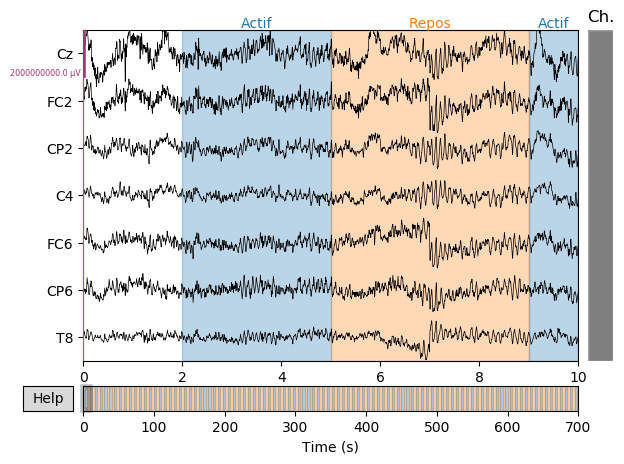

In [65]:
actif_onset_index = np.where(event_onset == 1)
actif_onsets = timevec[onset_index]
actif_duration = 3
actif_description = 'Actif'

repos_onsets = actif_onsets + actif_duration
repos_duration = 4
repos_description = 'Repos'

onsets = np.concatenate((actif_onsets, repos_onsets))
onsets = np.sort(onsets)

durations = []
descriptions = []
for i in range(0, int(len(onsets)/2)):
    durations.append(actif_duration)
    descriptions.append(actif_description)
    
    durations.append(repos_duration)
    descriptions.append(repos_description)
    
annotations = mne.Annotations(onsets, durations, descriptions)
raw_array.set_annotations(annotations)
raw_array.plot(scalings={'eeg':1000})

Effective window size : 4.000 (s)


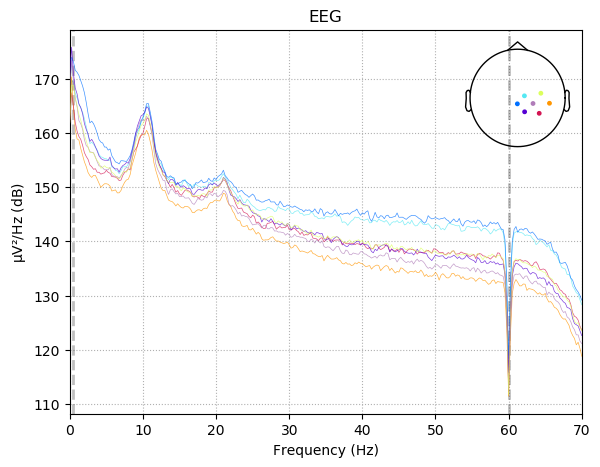

In [69]:
raw_array.plot_psd(fmax=70)

## Epoching

Used Annotations descriptions: ['Actif', 'Repos']


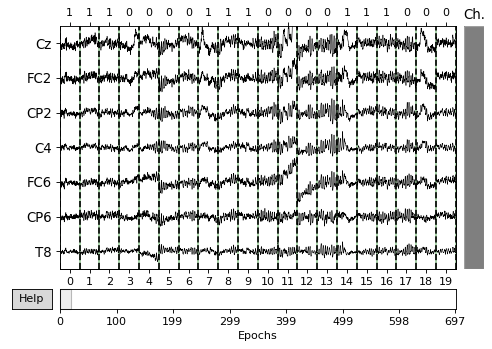

Channels marked as bad: []


In [117]:
event_id = {'Repos':0, 'Actif':1}
events, annot_event_id = mne.events_from_annotations(raw_array, event_id=event_id, chunk_duration=1)
epochs = mne.Epochs(raw=raw_array, events=events, event_id=event_id, tmin=0, tmax=1-(1/srate), preload=True, baseline=None, verbose=False)
epochs.plot(scalings={'eeg':1000})

## Spectrogram

In [111]:
FREQ_BANDS_RANGE = {
    'DELTA': [0.5, 4.5],
    'THETA': [4.5, 8.5],
    'ALPHA': [8.5, 11.5],
    'SIGMA': [11.5, 15.5],
    'BETA': [15.5, 30]
}

def get_psds_from_epochs(epochs):
    """Extracts power spectrum densities from epochs
    Returns
    --------
    psds with associated frequencies calculated with the welch method.
    """
    psds, freqs = psd_welch(epochs, fmin=0.5, fmax=30.)
    return psds, freqs

def get_mean_psds(psds_with_freqs, are_relative=False):
    """EEG power band feature extraction.
    Input
    -------
    psds_with_freqs: tuple which contains
            - (nb_epochs, nb_chan=1, nb_freqs) psds amplitudes
            - (nb_freqs,) corresponding frequency values
            
    are_relative: boolean which indicates if the mean band powers
        for each subband are relative to the total power or not.
    
    Returns
    -------
    X : numpy array of shape [n_samples, nb_subband=5]
        Transformed data.
    """
    psds = psds_with_freqs[0]
    freqs = psds_with_freqs[1]
    
    if are_relative:
        psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS_RANGE.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

powers, freqs = get_psds_from_epochs(epochs)
abs_mean_powers = get_mean_psds([powers, freqs])

abs_mean_powers_t = np.transpose(abs_mean_powers)
plt.pcolormesh(abs_mean_powers_t, vmin=0, vmax=10000)
plt.show()

Effective window size : 0.500 (s)


## Entrainement d'un modele avec les bandes de frequences pour les differents channels

### KNN

In [128]:
# Ces listes vont nous permettrent par la suite de visualiser l'evolution de la precision des modeles par rapport a leur
# complexite pour les classificateurs.
training_accuracy_clf = []
test_accuracy_clf = []

targets = events[:,2]

X_train, X_test, y_train, y_test = train_test_split(abs_mean_powers, targets, stratify=targets, random_state=66)

neighbors_settings = range(1, 20)

for n_neighbors in neighbors_settings:
    clf = KNeighborsClassifier(n_neighbors=n_neighbors) # un construit le modele
    clf.fit(X_train, y_train) # on l'entraine
    training_accuracy_clf.append(clf.score(X_train, y_train)) # on ajoute la precision selon le train_set a la liste
    test_accuracy_clf.append(clf.score(X_test, y_test)) # on ajoute la precision selon le test_set a la liste

plt.plot(neighbors_settings, training_accuracy_clf, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy_clf, label="test accuracy")
plt.title("KNN model accuracy for different K values")
plt.xlabel("K")
plt.ylabel("accuracy")
plt.legend()

## ameliorations
- a la place d'utiliser des epochs de 1 secondes en prendre de 3 secondes